# **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

2024-11-02 04:11:34.444174: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **Data Loading**

In [2]:
data = pd.read_csv("Train.csv")
data

Image_ID  confidence                      class         ymin  \
0      id_11543h.jpg         1.0      Pepper_Bacterial_Spot   194.649671   
1      id_11543h.jpg         1.0      Pepper_Bacterial_Spot   149.632401   
2      id_11543h.jpg         1.0      Pepper_Bacterial_Spot   234.046875   
3      id_11543h.jpg         1.0      Pepper_Bacterial_Spot   221.277138   
4      id_11ee1c.jpg         1.0            Pepper_Fusarium  2000.563598   
...              ...         ...                        ...          ...   
41024  id_38x7ln.jpg         1.0                Corn_Streak   608.472222   
41025  id_7uqmqp.jpg         1.0               Corn_Healthy  1483.095425   
41026  id_bnqorw.jpg         1.0  Corn_Cercospora_Leaf_Spot   943.260816   
41027  id_m2kklk.jpg         1.0            Tomato_Septoria  1855.337090   
41028  id_zie6j4.jpg         1.0            Tomato_Septoria  2885.765343   

              xmin         ymax         xmax  
0       328.803454   208.107730   341.967928  
1       256.768914   162.910362   266.195724  
2       327.138158   252.712993   338.876645  
3       340.411184   238.593750   354.651316  
4       989.588908  2184.252196  1401.748952  
...            ...          ...          ...  
41024   817.741770   736.352881   997.047325  
41025   818.249483  1786.752393  1152.860096  
41026  1015.079256  1007.928503  1133.177119  
41027  1748.733977  2046.688525  1868.580553  
41028  2666.672615  3024.000000  2832.242863  

[41029 rows x 7 columns]

In [3]:
data.head()

Image_ID  confidence                  class         ymin        xmin  \
0  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   194.649671  328.803454   
1  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   149.632401  256.768914   
2  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   234.046875  327.138158   
3  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   221.277138  340.411184   
4  id_11ee1c.jpg         1.0        Pepper_Fusarium  2000.563598  989.588908   

          ymax         xmax  
0   208.107730   341.967928  
1   162.910362   266.195724  
2   252.712993   338.876645  
3   238.593750   354.651316  
4  2184.252196  1401.748952

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41029 entries, 0 to 41028
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Image_ID    41029 non-null  object 
 1   confidence  41029 non-null  float64
 2   class       41029 non-null  object 
 3   ymin        41029 non-null  float64
 4   xmin        41029 non-null  float64
 5   ymax        41029 non-null  float64
 6   xmax        41029 non-null  float64
dtypes: float64(5), object(2)
memory usage: 2.2+ MB


In [5]:
disease_counts = data['class'].value_counts()
# disease_counts

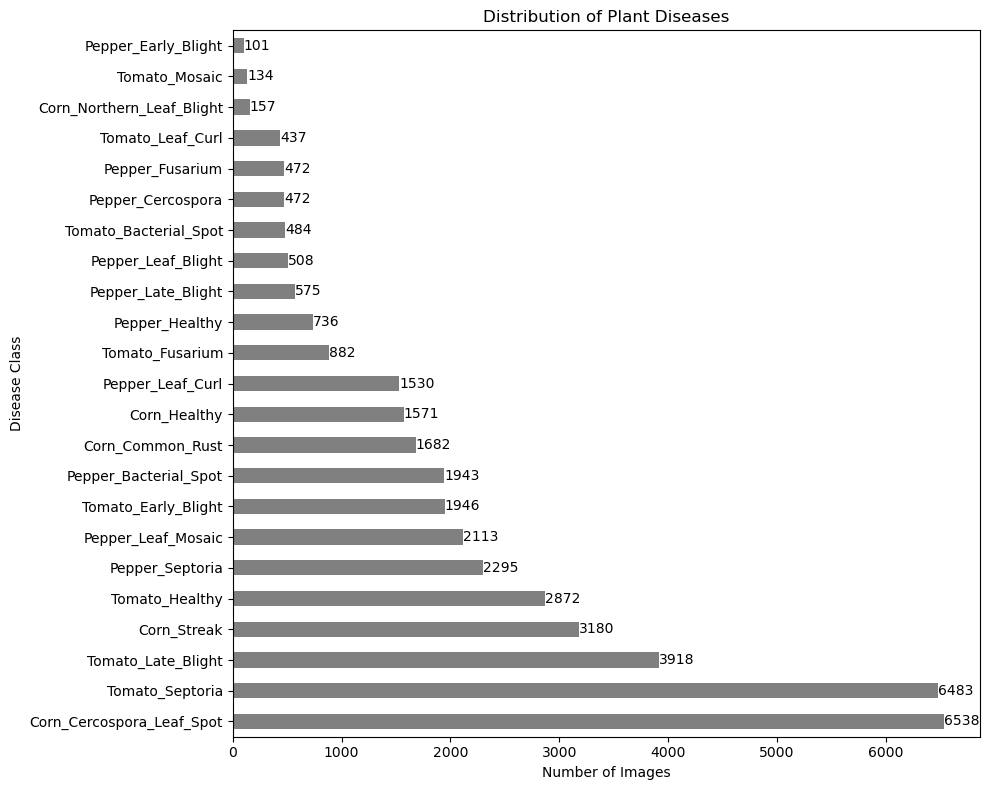

In [6]:
plt.figure(figsize=(10, 8))
bar = disease_counts.plot(kind='barh', color='grey')
for index, value in enumerate(disease_counts):
    plt.text(value, index, str(value), va='center')

plt.title('Distribution of Plant Diseases')
plt.xlabel('Number of Images')
plt.ylabel('Disease Class')
plt.tight_layout()
plt.show()

# **Image Data Visualization**

In [7]:
sample_data = data.sample(10)

In [8]:
image_folder = 'images/'

In [10]:
def visualize_bounding_boxes(image_id, boxes, disease_name):
    # Load the image
    img_path = os.path.join(image_folder, image_id)
    img = Image.open(img_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    # Draw the bounding box
    for box in boxes:
        ymin, xmin, ymax, xmax = box
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    # Add the disease name
    plt.title(f"Disease: {disease_name}")
    plt.show()

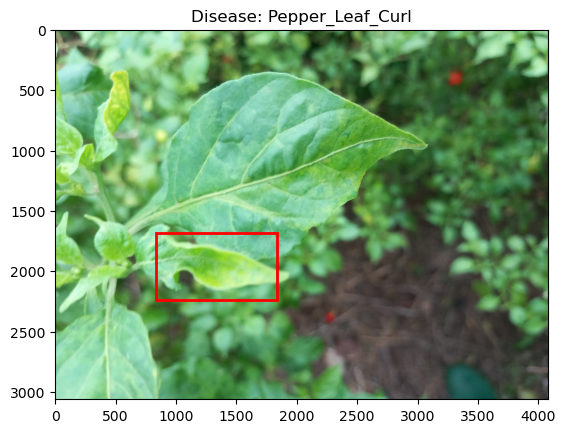

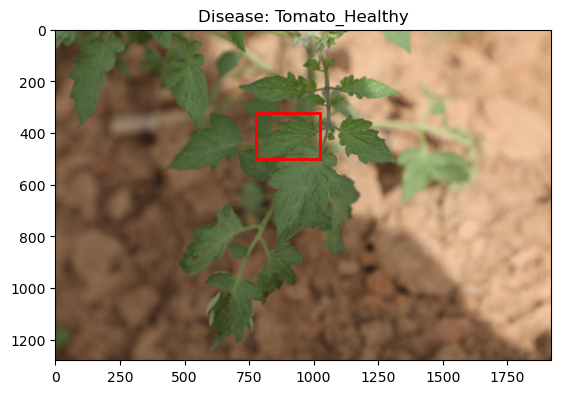

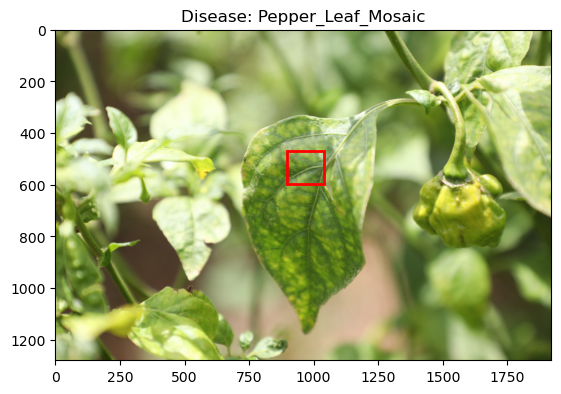

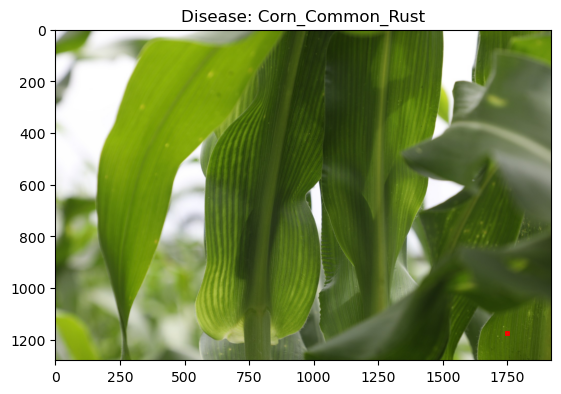

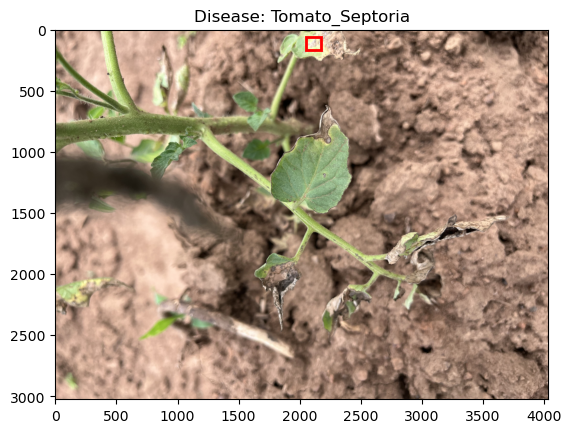

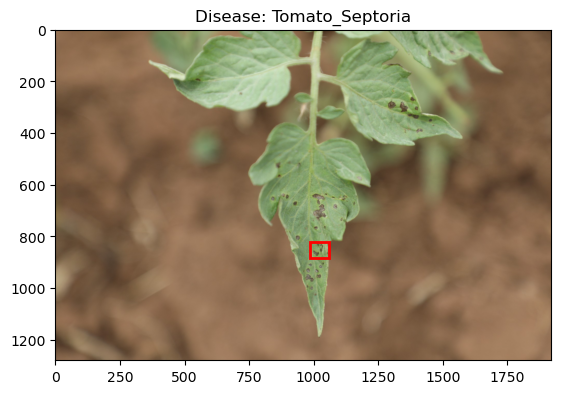

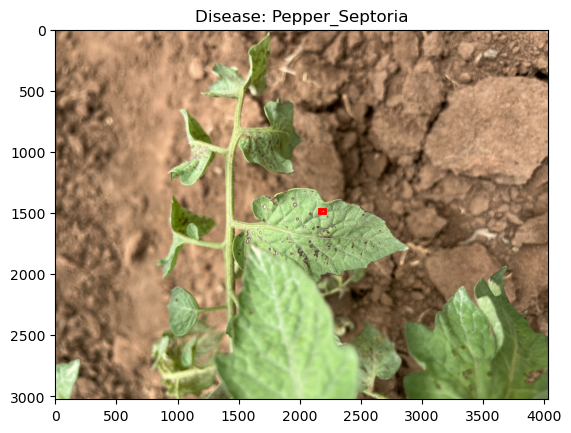

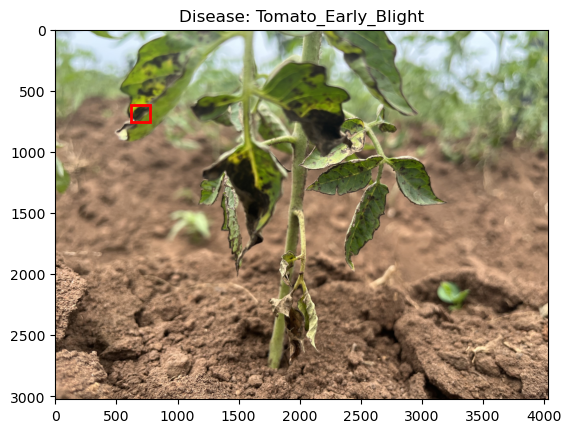

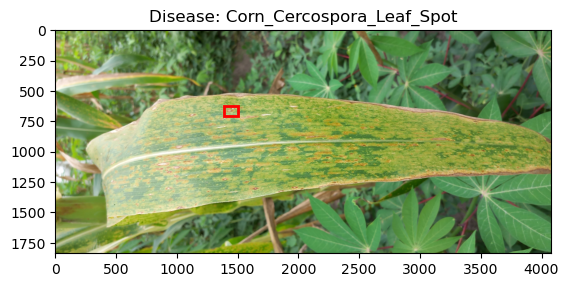

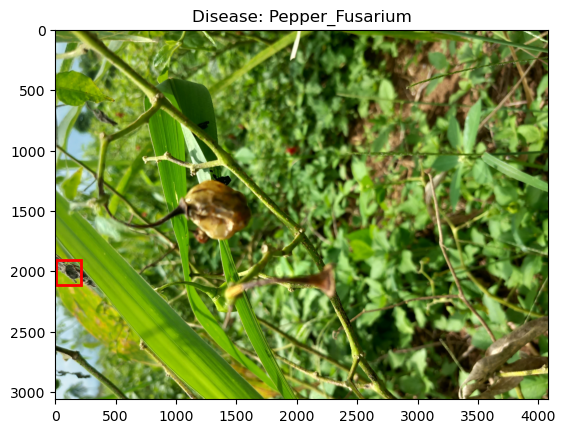

In [11]:
# Iterate over the selected images and visualize
for idx, row in sample_data.iterrows():
    image_id = row['Image_ID']
    disease_name = row['class']
    
    # Extract the bounding box coordinates
    ymin = row['ymin']
    xmin = row['xmin']
    ymax = row['ymax']
    xmax = row['xmax']
    
    # Visualize the image with bounding box and disease name
    visualize_bounding_boxes(image_id, [(ymin, xmin, ymax, xmax)], disease_name)

# **MobileNet**

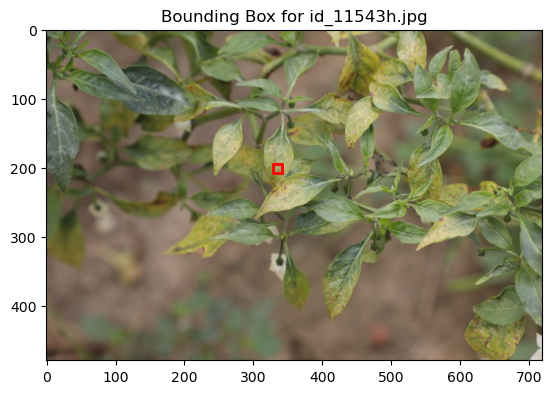

In [12]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    image_resized = image.resize((224, 224))  # Resize image to 224x224
    image_array = np.array(image_resized) / 255.0
    return np.expand_dims(image_array, axis=0)

# Function to crop the bounding box area and resize
def crop_with_bounding_box(image_path, xmin, ymin, xmax, ymax):
    image = Image.open(image_path)
    cropped_image = image.crop((xmin, ymin, xmax, ymax))
    cropped_image_resized = cropped_image.resize((224, 224))  # Resize cropped area
    cropped_image_array = np.array(cropped_image_resized) / 255.0
    return np.expand_dims(cropped_image_array, axis=0)

# Display an image with bounding box
def display_image_with_bbox(image_path, bbox):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    # Draw bounding box
    xmin, ymin, xmax, ymax = bbox
    rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.title(f"Bounding Box for {image_path.split('/')[-1]}")
    plt.show()

# Test on one sample from dataset
sample_row = data.iloc[0]
image_path = os.path.join(image_folder, sample_row['Image_ID'])
bbox = (sample_row['xmin'], sample_row['ymin'], sample_row['xmax'], sample_row['ymax'])
display_image_with_bbox(image_path, bbox)

**Build The Model**

In [13]:
from tensorflow.keras.applications import EfficientNetB0

In [14]:
# Load the EfficientNetB0 model without the top layers
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Add classification layers on top
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(len(data['class'].unique()), activation='softmax')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 5,384,890 (20.54 MB)

 Trainable params: 5,342,867 (20.38 MB)

 Non-trainable params: 42,023 (164.16 KB)

**Process full image and bounding box for training**

In [15]:
# Example: Preprocess full image and bounding box for the entire dataset
def process_data_for_model(data, image_folder):
    X_full = []
    X_bbox = []
    y = []
    
    for idx, row in data.iterrows():
        image_path = os.path.join(image_folder, row['Image_ID'])
        
        # Full image
        full_image = preprocess_image(image_path)
        X_full.append(full_image)
        
        # Bounding box region
        bbox = (row['xmin'], row['ymin'], row['xmax'], row['ymax'])
        cropped_image = crop_with_bounding_box(image_path, *bbox)
        X_bbox.append(cropped_image)
        
        # Label
        y.append(row['class'])
    
    # Convert lists to arrays
    X_full = np.vstack(X_full)
    X_bbox = np.vstack(X_bbox)
    
    return X_full, X_bbox, y

# Process the full dataset
X_full, X_bbox, y = process_data_for_model(data, image_folder)

KeyboardInterrupt: 

**Train The Model**

In [ ]:
import pandas as pd

def save_predictions_to_csv(predictions, image_ids, file_path='predictions.csv'):
    """
    Saves predictions to a CSV file in the required format.
    
    Args:
        predictions (array): Array of predicted class probabilities or class labels.
        image_ids (list): List of image IDs corresponding to the predictions.
        file_path (str): Path where the CSV will be saved.
    """
    # Initialize a list to store each row as a dictionary
    results = []
    
    for i, pred in enumerate(predictions):
        image_id = image_ids[i]
        
        # Assuming `pred` is an array of class probabilities or class label
        # If using probabilities, get the class with the highest probability
        class_idx = pred.argmax() if len(pred.shape) > 1 else pred
        confidence = pred.max() if len(pred.shape) > 1 else 1.0
        
        # Dummy bounding box values (replace with actual values if using bounding boxes)
        ymin, xmin, ymax, xmax = 0, 0, 100, 100  # Example box coordinates; replace as needed
        
        results.append({
            'Image_ID': image_id,
            'class': label_encoder.inverse_transform([class_idx])[0],
            'confidence': confidence,
            'ymin': ymin,
            'xmin': xmin,
            'ymax': ymax,
            'xmax': xmax
        })
    
    # Convert results to DataFrame and save as CSV
    df = pd.DataFrame(results)
    df.to_csv(file_path, index=False)
    print(f"Predictions saved to {file_path}")


**Fine-tune using bounding box refinement**

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train the model on full images
model.fit(X_bbox, y_categorical, validation_split=0.2, epochs=5)

# Make predictions on the test set
test_predictions = model.predict(X_full)  
test_image_ids = [img_id for img_id in test_data['Image_ID']]  

# Save predictions to CSV
save_predictions_to_csv(test_predictions, test_image_ids)
